In [1]:
%matplotlib inline
import os
from subprocess import call

import xarray as xr
import numpy as np
import cftime
import dask

from scipy import signal

from itertools import product

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import  matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmocean

import geotools as gt
import plottools as pt
import project as P

USER = os.environ['USER']

In [2]:
xr_open_ds = {'chunks' : {'time':1},
              'decode_coords' : False,
              'decode_times' : False}
xr.set_options(enable_cftimeindex=True)

year_range = np.array((249,316))+1699
time = [cftime.DatetimeNoLeap(year, month, 1) for year, month in 
                  product(range(year_range[0], year_range[1]+1), range(1, 13))]
ypm = np.array([31,28,31,30,31,30,31,31,30,31,30,31])/365
wgt = xr.DataArray(np.tile(ypm,int(np.diff(year_range)+1)),dims=('time'),coords={'time':time})

np.testing.assert_allclose(wgt.groupby('time.year').sum(),1.)

In [3]:
extent = [120,260,10,65]
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
prj = ccrs.Mercator(central_longitude=np.mean(extent[0:2]),
                    min_latitude=extent[2],
                    max_latitude=extent[3])

In [4]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

dask.config.set({'distributed.dashboard.link':'http://localhost:{port}/status'})

# Lots of arguments to this command are set in ~/.config/dask/jobqueue.yaml
cluster = PBSCluster(queue='regular',
                     cores = 36,
                     processes = 9,
                     memory = '100GB',                     
                     project = 'NCGD0033',
                     walltime = '04:00:00',
                     local_directory=f'/glade/scratch/{USER}/dask-tmp')
client = Client(cluster)

In [5]:
Nnodes = 4
cluster.scale(9*Nnodes)

## Read datasets

In [6]:
droot = '/glade/p_old/decpred/CESM-DPLE_POPCICEhindcast'
variables = ['PD','O2','PV','HMXL','HBLT','TEMP','SALT','SSH']
ds = xr.Dataset()
for v in variables:
    ds = xr.merge((ds,xr.open_dataset(f'{droot}/g.e11_LENS.GECOIAF.T62_g16.009.pop.h.{v}.024901-031612.nc',**xr_open_ds)))

ds.time.values = time
year = np.array([d.year for d in ds.time.values])
yearfrac = year + np.tile(np.cumsum(ypm),np.diff(year_range)+1)

ds = ds.isel(nlat=slice(187,331),nlon=slice(137,276))

ds['dPD'] = (ds.PD.sel(z_t=600e2,method='nearest') - ds.PD.sel(z_t=200e2,method='nearest'))*1000.
variables = variables+['dPD']

#ds = ds.sel(z_t=slice(200e2,600e2)).mean('z_t')
ds = ds.sel(z_t=200e2,method='nearest')

ds['PV'] = np.fabs(ds.PV)

grid_vars = [v for v in ds.variables if 'time' not in ds[v].dims]+['time_bound']

## Compute monthly anomalies from climatology

In [7]:
nx = np.where((P.year_range_clim.start <= year) & (year <= P.year_range_clim.stop))[0]
dsm = ds.drop(grid_vars).isel(time=nx).groupby('time.month').mean('time')
dsyc = ds.groupby('time.month') - dsm
dsyc = xr.merge((dsyc,ds.drop(variables))) # put the grid_vars back

In [8]:
pdo = P.load_pdo(year_range,apply_ann_filter=True)
npgo = P.load_npgo(year_range,apply_ann_filter=True)

In [9]:
R = xr.Dataset()
R['PV'] = P.xcorr(dsyc.PV,dsyc.O2,dim='time').compute()
R['dPD'] = P.xcorr(dsyc.dPD,dsyc.O2,dim='time').compute()
R['PD'] = P.xcorr(dsyc.PD,dsyc.O2,dim='time').compute()
R['HMXL'] = P.xcorr(dsyc.HMXL,dsyc.O2,dim='time').compute()
R['PDO'] = P.xcorr(pdo.PDO,dsyc.O2,dim='time').compute()
R['PDO_v_HMXL'] = P.xcorr(pdo.PDO,dsyc.HMXL,dim='time').compute()
R['PDO_v_PD'] = P.xcorr(pdo.PDO,dsyc.PD,dim='time').compute()

In [10]:
R['TEMP'] = P.xcorr(dsyc.TEMP,dsyc.O2,dim='time').compute()
R['SALT'] = P.xcorr(dsyc.SALT,dsyc.O2,dim='time').compute()

In [11]:
R['SSH'] = P.xcorr(dsyc.SSH,dsyc.O2,dim='time').compute()

In [12]:
R['SSH_v_PD'] = P.xcorr(dsyc.SSH,dsyc.PD,dim='time').compute()

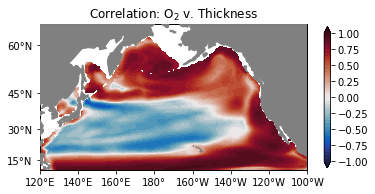

In [13]:
old_err_settings = np.seterr(invalid='ignore')

cf_specs = {'levels':np.arange(-1,1.05,0.05),
            'cmap':cmocean.cm.balance,
            'extend':'both'} 

fig = plt.figure()
ax = fig.add_subplot(111,projection=prj) 
ax.set_extent(extent)  
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,R.dPD.values)
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                  edgecolor='face',
                  facecolor='gray'),zorder=100)
ax.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(cf,shrink=0.65)
ax.set_title('Correlation: O$_2$'' v. Thickness')

plt.savefig(f'{P.dirf}/npac-thermocline-o2-xcorr-thickness.pdf',bbox_inches='tight')

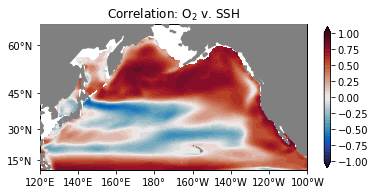

In [14]:
old_err_settings = np.seterr(invalid='ignore')

cf_specs = {'levels':np.arange(-1,1.05,0.05),
            'cmap':cmocean.cm.balance,
            'extend':'both'} 

fig = plt.figure()
ax = fig.add_subplot(111,projection=prj) 
ax.set_extent(extent)  
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,R.SSH.values)
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                  edgecolor='face',
                  facecolor='gray'),zorder=100)
ax.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(cf,shrink=0.65)
ax.set_title('Correlation: O$_2$'' v. SSH')

plt.savefig(f'{P.dirf}/npac-thermocline-o2-xcorr-ssh.pdf',bbox_inches='tight')

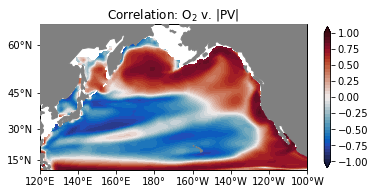

In [15]:
old_err_settings = np.seterr(invalid='ignore')

cf_specs = {'levels':np.arange(-1,1.05,0.05),
            'cmap':cmocean.cm.balance,
            'extend':'both'} 

fig = plt.figure()
ax = fig.add_subplot(111,projection=prj) 
ax.set_extent(extent)  
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,R.PV.values)
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                  edgecolor='face',
                  facecolor='gray'),zorder=100)
ax.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(cf,shrink=0.65)
ax.set_title('Correlation: O$_2$'' v. |PV|')

plt.savefig(f'{P.dirf}/npac-thermocline-o2-xcorr-pv.pdf',bbox_inches='tight')

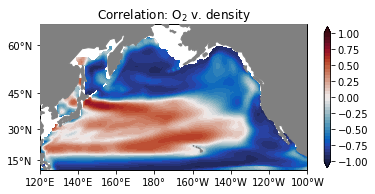

In [16]:
old_err_settings = np.seterr(invalid='ignore')

cf_specs = {'levels':np.arange(-1,1.05,0.05),
            'cmap':cmocean.cm.balance,
            'extend':'both'} 

fig = plt.figure()
ax = fig.add_subplot(111,projection=prj) 
ax.set_extent(extent)  
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,R.PD.values)
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                  edgecolor='face',
                  facecolor='gray'),zorder=100)
ax.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(cf,shrink=0.65)
ax.set_title('Correlation: O$_2$'' v. density')

plt.savefig(f'{P.dirf}/npac-thermocline-o2-xcorr-density.pdf',bbox_inches='tight')

Text(0.5, 1.0, 'Correlation: O$_2$ v. mixed layer depth')

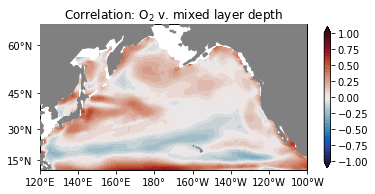

In [17]:
old_err_settings = np.seterr(invalid='ignore')

cf_specs = {'levels':np.arange(-1,1.05,0.05),
            'cmap':cmocean.cm.balance,
            'extend':'both'} 

fig = plt.figure()
ax = fig.add_subplot(111,projection=prj) 
ax.set_extent(extent)  
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,R.HMXL.values)
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                  edgecolor='face',
                  facecolor='gray'),zorder=100)
ax.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(cf,shrink=0.65)
ax.set_title('Correlation: O$_2$'' v. mixed layer depth')

Text(0.5, 1.0, 'Correlation: O$_2$ v. potential temperature')

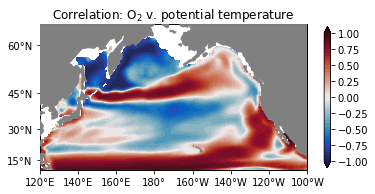

In [18]:
old_err_settings = np.seterr(invalid='ignore')

cf_specs = {'levels':np.arange(-1,1.05,0.05),
            'cmap':cmocean.cm.balance,
            'extend':'both'} 

fig = plt.figure()
ax = fig.add_subplot(111,projection=prj) 
ax.set_extent(extent)  
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,R.TEMP.values)
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                  edgecolor='face',
                  facecolor='gray'),zorder=100)
ax.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(cf,shrink=0.65)
ax.set_title('Correlation: O$_2$'' v. potential temperature')

Text(0.5, 1.0, 'Correlation: O$_2$ v. salinity')

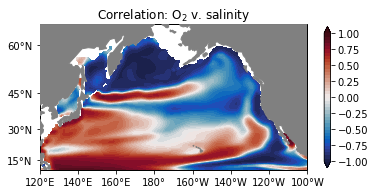

In [19]:
old_err_settings = np.seterr(invalid='ignore')

cf_specs = {'levels':np.arange(-1,1.05,0.05),
            'cmap':cmocean.cm.balance,
            'extend':'both'} 

fig = plt.figure()
ax = fig.add_subplot(111,projection=prj) 
ax.set_extent(extent)  
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,R.SALT.values)
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                  edgecolor='face',
                  facecolor='gray'),zorder=100)
ax.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(cf,shrink=0.65)
ax.set_title('Correlation: O$_2$'' v. salinity')

Text(0.5, 1.0, 'Correlation: O$_2$ v. PDO')

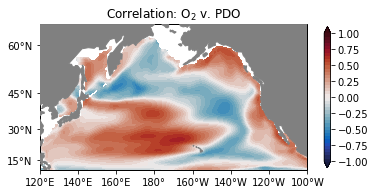

In [20]:
old_err_settings = np.seterr(invalid='ignore')

cf_specs = {'levels':np.arange(-1,1.05,0.05),
            'cmap':cmocean.cm.balance,
            'extend':'both'} 

fig = plt.figure()
ax = fig.add_subplot(111,projection=prj) 
ax.set_extent(extent)  
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,R.PDO.values)
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                  edgecolor='face',
                  facecolor='gray'),zorder=100)
ax.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(cf,shrink=0.65)
ax.set_title('Correlation: O$_2$'' v. PDO')

Text(0.5, 1.0, 'Correlation: density v. PDO')

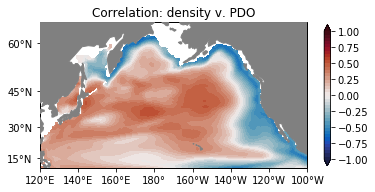

In [21]:
old_err_settings = np.seterr(invalid='ignore')

cf_specs = {'levels':np.arange(-1,1.05,0.05),
            'cmap':cmocean.cm.balance,
            'extend':'both'} 

fig = plt.figure()
ax = fig.add_subplot(111,projection=prj) 
ax.set_extent(extent)  
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,R.PDO_v_PD.values)
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                  edgecolor='face',
                  facecolor='gray'),zorder=100)
ax.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(cf,shrink=0.65)
ax.set_title('Correlation: density v. PDO')

Text(0.5, 1.0, 'Correlation: HMXL v. PDO')

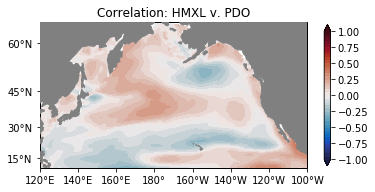

In [22]:
cf_specs = {'levels':np.arange(-1,1.05,0.05),
            'cmap':cmocean.cm.balance,
            'extend':'both'} 

fig = plt.figure()
ax = fig.add_subplot(111,projection=prj) 
ax.set_extent(extent)  
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,R.PDO_v_HMXL.values)
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                  edgecolor='face',
                  facecolor='gray'),zorder=100)
ax.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(cf,shrink=0.65)
ax.set_title('Correlation: HMXL v. PDO')

In [23]:
dsann = (dsm*xr.DataArray(ypm,dims='month')).sum('month')

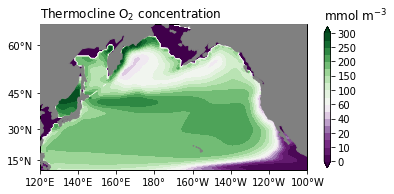

In [24]:
norm_o2 = pt.MidPointNorm(midpoint=60.)
cf_specs = {'levels':[0,5,10,15,20,30,40,50,60,80,100,125,150,175,200,225,250,275,300],
            'cmap':'PRGn',
            'norm':norm_o2,
            'extend':'both'} 


fig = plt.figure()
ax = fig.add_subplot(111,projection=prj) 
ax.set_extent(extent)  
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,dsann.O2.values)
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                  edgecolor='face',
                  facecolor='gray'),zorder=100)
ax.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(cf,shrink=0.65)
ax.set_title('Thermocline O$_2$ concentration',loc='left')
cb.ax.set_title('mmol m$^{-3}$',loc='left')

plt.savefig(f'{P.dirf}/npac-mean-thermocline-o2.pdf',bbox_inches='tight')

In [28]:
dsyr = P.regional_mean(dsyc.drop('z_t'))
dsyr = dsyr.compute()

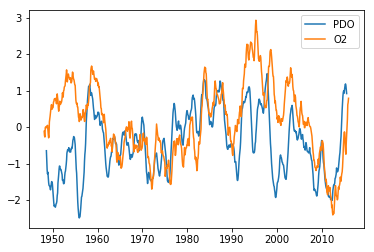

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(yearfrac,pdo.PDO,label='PDO')
ax.plot(yearfrac,dsyr.O2/dsyr.O2.std(),label='O2')

plt.legend()


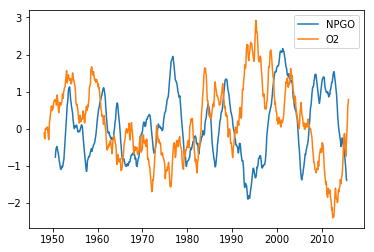

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(yearfrac[yearfrac>1950.],npgo.NPGO,label='NPGO')
ax.plot(yearfrac,dsyr.O2/dsyr.O2.std(),label='O2')
plt.legend()

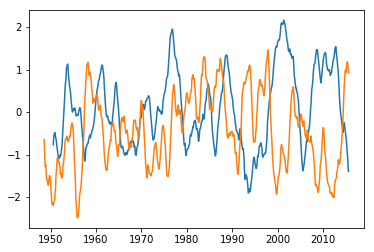

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(yearfrac[yearfrac>1950.],npgo.NPGO)
ax.plot(yearfrac,pdo.PDO)

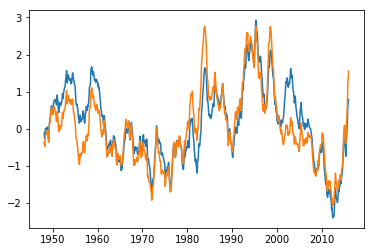

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(yearfrac,dsyr.O2/dsyr.O2.std())
ax.plot(yearfrac,-dsyr.PD/dsyr.PD.std())


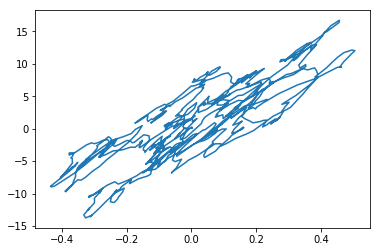

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(dsyr.TEMP,dsyr.O2)

### compute EOFs
https://ajdawson.github.io/eofs/api/eofs.xarray.html#eofs.xarray.Eof

In [92]:
from eofs.xarray import Eof
wgts = ds.TAREA
solver = Eof(dsyc.O2,weights=wgts)

pcs = solver.pcs(npcs=3,pcscaling=1) # PCs scaled to unit-variance
eofs = solver.eofs(neofs=3,eofscaling=1)
variance_fractions = solver.varianceFraction()

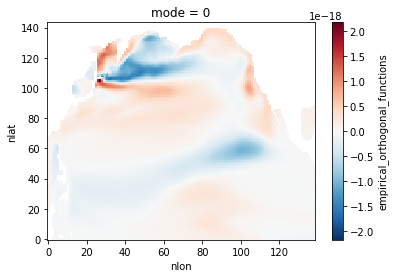

In [84]:
eofs.isel(mode=0).plot()

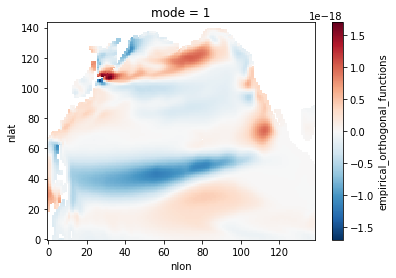

In [85]:
eofs.isel(mode=1).plot()

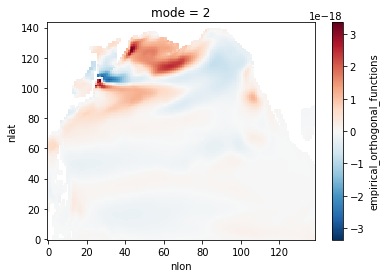

In [93]:
eofs.isel(mode=2).plot()

In [126]:
o2 = dsyc.O2.compute()
pcs = pcs.compute()

In [127]:
def regress(x):
    pf = np.polyfit(pcs.isel(mode=0),x,1)
    return xr.DataArray(pf[0])

x = o2.stack({'lateral_dims':['nlat','nlon']})
r = x.groupby('lateral_dims').apply(regress).unstack('lateral_dims')

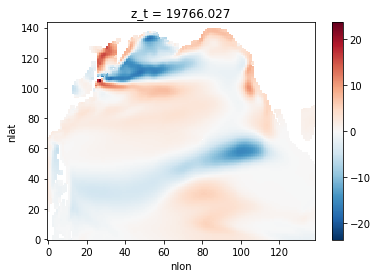

In [128]:
r.plot()